# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from pathlib import Path
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from dataclasses import dataclass
from sklearn.metrics import precision_score, f1_score

In [ ]:
from utils.dataset_split import DatasetSplit

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [ ]:
file_name = "A_12_20130925_1212_01_2.txt"

In [ ]:
process_annotations(file_name, "annotations_per_t.csv")

Per-second annotations saved to /content/drive/MyDrive/ISIR/RedBallGame/final/annotations_per_t.csv


## Annotations categorization

In [ ]:
df = pd.read_csv("annotations_per_t.csv")

In [ ]:
df['Annotation'] = df.apply(
    lambda row: categorize_facial_mot(row['Annotation']) if row['Tier'] == 'Facial@MOT' else
                categorize_utterance_mot(row['Annotation']) if row['Tier'] == 'Utterance@MOT' else
                categorize_gaze_mot(row['Annotation']) if row['Tier'] == 'Gaze@MOT' else
                categorize_gaze_chi(row['Annotation']) if row['Tier'] == 'Gaze@CHI' else
                row['Annotation'],
    axis=1
)

## Create objects

### Standard

In [ ]:
tiers = [
    "Action@MOT",
    "Gaze@MOT",
    "Utterance@MOT",
    "Prosody@MOT",
    "Facial@MOT",
    "Laughter@MOT",
    "Laughter@CHI",
    "Gaze@CHI"
]

pivot_df = df.pivot_table(
    index='Time',
    columns='Tier',
    values='Annotation',
    aggfunc=lambda x: x.iloc[0]
)

pivot_df = pivot_df[tiers]

pivot_df = pivot_df.where(pd.notnull(pivot_df), None)

records = pivot_df.to_dict(orient='records')

X = records.copy()

### With GazeRelation

In [ ]:
tiersGR = [
    "Action@MOT",
    "Gaze@MOT",
    "Utterance@MOT",
    "Prosody@MOT",
    "Facial@MOT",
    "Laughter@MOT",
    "Laughter@CHI",
    "Gaze@CHI",
    "GazeRelation"
]
pivot_gr_df = df.pivot_table(
    index='Time',
    columns='Tier',
    values='Annotation',
    aggfunc=lambda x: x.iloc[0]
)

records_gr = pivot_gr_df.to_dict(orient='records')

for record in records_gr:
    mot_target = record.get("Gaze@MOT")
    chi_target = record.get("Gaze@CHI")

    if chi_target == "mom" and mot_target == "child":
        label = "MA"  # MutualAttention
    elif mot_target == "invisible":
        label = "<UNK>"  # Unknown
    elif chi_target == "mom":
        label = "SA(CHI)"  # SingleAttention(CHI)
    elif mot_target == "child":
        label = "SA(MOT)"  # SingleAttention(MOT)
    elif chi_target == mot_target and chi_target is not None:
        label = "ShA"  # SharedAttention
    elif chi_target != mot_target:
        label = "L"  # LostAttention
    else:
        label = "<UNK>"  # Unknown

    record["GazeRelation"] = label

pivot_gr_df = pd.DataFrame(records_gr)

pivot_gr_df = pivot_gr_df[tiersGR]

pivot_gr_df = pivot_gr_df.where(pd.notnull(pivot_gr_df), None)

records_gr = pivot_gr_df.to_dict(orient='records')

X_gr = records_gr.copy()

## Retrieve vocabs

In [ ]:
values = defaultdict(set)

for r in records_gr:
    for key in r.keys():
        value = r[key]
        if value is None or value == '' or value == 'invisible':
            value = "<UNK>"  # use <UNK> token for missing
        values[key].add(value)

vocab_action    = {token: idx for idx, token in enumerate(sorted(values['Action@MOT']))}
vocab_gaze      = {token: idx for idx, token in enumerate(sorted(values['Gaze@MOT']))}
vocab_utterance = {token: idx for idx, token in enumerate(sorted(values['Utterance@MOT']))}
vocab_prosody   = {token: idx for idx, token in enumerate(sorted(values['Prosody@MOT']))}
vocab_facial    = {token: idx for idx, token in enumerate(sorted(values['Facial@MOT']))}
vocab_laughter  = {token: idx for idx, token in enumerate(sorted(values['Laughter@MOT']))}
vocab_laughter_chi = {token: idx for idx, token in enumerate(sorted(values['Laughter@CHI']))}
vocab_gaze_chi  = {token: idx for idx, token in enumerate(sorted(values['Gaze@CHI']))}
vocab_gazerelation  = {token: idx for idx, token in enumerate(sorted(values['GazeRelation']))}

In [ ]:
vocabs = {"action": vocab_action, "gaze": vocab_gaze, "utterance": vocab_utterance,
          "prosody": vocab_prosody, "facial": vocab_facial, "laughter": vocab_laughter,
          "laughter_chi": vocab_laughter_chi, "gaze_chi": vocab_gaze_chi}

vocabs_gr = {"action": vocab_action, "gaze": vocab_gaze, "utterance": vocab_utterance,
             "prosody": vocab_prosody, "facial": vocab_facial, "laughter": vocab_laughter,
             "gazerelation": vocab_gazerelation, "laughter_chi": vocab_laughter_chi, "gaze_chi": vocab_gaze_chi}

# Helper functions

In [ ]:
def get_data(isGazeRelation):
    if isGazeRelation:
        return X_gr, vocabs_gr
    else:
        return X, vocabs

## Data Loader (batches divsion)

In [ ]:
from torch.utils.data import DataLoader

# Finding the index of a value in a vocabulary
def lookup(vocab, value):
    if value is None:
        value = "<UNK>"
    return vocab.get(value, vocab["<UNK>"])

def collate_fn(batch):
    """
    Collate function for DataLoader without GazeRelation target.
    Processes a batch of data into input sequences and target tensors.
    """
    sequences, targets_list = zip(*batch)  # Separate inputs and targets

    target_laughter_indices = []
    target_gaze_indices = []

    # Convert each target value to an index
    for target_dict in targets_list:
        laughter_val = target_dict.get('Laughter@CHI')
        gaze_val = target_dict.get('Gaze@CHI')

        target_laughter_indices.append(lookup(vocab_laughter_chi, laughter_val))
        target_gaze_indices.append(lookup(vocab_gaze_chi, gaze_val))

    # Convert target index lists to tensors
    targets_laughter = torch.tensor(target_laughter_indices, dtype=torch.long)
    targets_gaze = torch.tensor(target_gaze_indices, dtype=torch.long)

    # Wrap each sequence dict in a list to create a sequence of length 1
    X_batch_sequences = [[seq_dict] for seq_dict in sequences]

    return X_batch_sequences, (targets_gaze, targets_laughter)

def collate_fn_gr(batch):
    """
    Collate function for DataLoader with GazeRelation target.
    Same as collate_fn but also processes the 'GazeRelation' target.
    """
    sequences, targets_list = zip(*batch)

    target_laughter_indices = []
    target_gaze_indices = []
    target_gazerelation_indices = []

    for target_dict in targets_list:
        laughter_val = target_dict.get('Laughter@CHI')
        gaze_val = target_dict.get('Gaze@CHI')
        gazerelation_val = target_dict.get('GazeRelation')

        target_laughter_indices.append(lookup(vocab_laughter_chi, laughter_val))
        target_gaze_indices.append(lookup(vocab_gaze_chi, gaze_val))
        target_gazerelation_indices.append(lookup(vocab_gazerelation, gazerelation_val))

    # Convert lists to tensors
    targets_laughter = torch.tensor(target_laughter_indices, dtype=torch.long)
    targets_gaze = torch.tensor(target_gaze_indices, dtype=torch.long)
    targets_gazerelation = torch.tensor(target_gazerelation_indices, dtype=torch.long)

    # Wrap each sequence dict in a list to create a sequence of length 1
    X_batch_sequences = [[seq_dict] for seq_dict in sequences]

    return X_batch_sequences, (targets_gaze, targets_laughter, targets_gazerelation)

def get_loader(X, y, batch_size, isGazeRelation):
    """
    Creates a DataLoader for the given dataset.
    """
    dataset = MultimodalDataset(X, y)
    if isGazeRelation:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_gr)
    else:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return loader


In [ ]:
def get_loaders(X, isGazeRelation, isMixedPhases, train_size, val_size, n_parts):
    """
    Splits the dataset into train/validation/test sets and returns DataLoaders for each.
    """
    # If phases are not mixed, process the dataset as a single part
    if not isMixedPhases:
        n_parts = 1

    # Split the dataset into train, validation, and test subsets
    X_train, y_train, X_val, y_val, X_test, y_test = DatasetSplit(
        dataset=X,
        n_parts=n_parts,
        train_size=train_size,
        val_size=val_size
    ).main()

    # Determine batch sizes so that each phase is represented in a batch
    train_batch_size = len(X_train) // n_parts
    val_batch_size = len(X_val) // n_parts
    test_batch_size = len(X_test) // n_parts

    # Create DataLoaders for each subset
    train_loader = get_loader(X_train, y_train, batch_size=train_batch_size, isGazeRelation=isGazeRelation)
    val_loader = get_loader(X_val, y_val, batch_size=val_batch_size, isGazeRelation=isGazeRelation)
    test_loader = get_loader(X_test, y_test, batch_size=test_batch_size, isGazeRelation=isGazeRelation)

    return train_loader, val_loader, test_loader


## Datasets

### Split dataset

In [ ]:
class DatasetSplit:
    def __init__(self, dataset, n_parts = 4, train_size = 0.5, val_size = 0.25):
          self.n_parts = n_parts
          self.train_size = train_size
          self.val_size = val_size

          self.dataset = dataset
          self.n = len(dataset)
          self.part_size = self.n // n_parts

    def split_dataset(self):
        train_idx, val_idx, test_idx = [], [], []

        for i in range(self.n_parts):
            start = i * self.part_size
            end = (i + 1) * self.part_size if i < self.n_parts - 1 else self.n

            part_indices = np.arange(start, end)

            n_train = int(len(part_indices) * self.train_size)
            n_val = int(len(part_indices) * self.val_size)

            train_idx.extend(part_indices[:n_train])
            val_idx.extend(part_indices[n_train:n_train + n_val])
            test_idx.extend(part_indices[n_train + n_val:])

        X_train = [X[i] for i in train_idx]
        X_validation = [X[i] for i in val_idx]
        X_test = [X[i] for i in test_idx]
        return X_train, X_validation, X_test

    def get_features_and_targets(self, dataset):
          X = []
          y = []

          for record in dataset:
              target = {}
              input = {}

              for key, value in record.items():
                  if key in ['Laughter@CHI', 'Gaze@CHI', 'GazeRelation']:
                      target[key] = value
                  else:
                      input[key] = value
              X.append(input)
              y.append(target)

          return X, y

    def main(self):
        train, validation, test = self.split_dataset()

        X_train, y_train = self.get_features_and_targets(train)
        X_validation, y_validation = self.get_features_and_targets(validation)
        X_test, y_test = self.get_features_and_targets(test)

        return X_train, y_train, X_validation, y_validation, X_test, y_test

# Dataset Analysis

In [ ]:
# Split dataset
X_train, y_train, X_val, y_val, X_test, y_test = DatasetSplit(
    dataset=X,
    n_parts=1,
    train_size=0.5,
    val_size=0.25
).main()

# Convert to DataFrames
y_train_df = pd.DataFrame(y_train)
y_val_df = pd.DataFrame(y_val)
y_test_df = pd.DataFrame(y_test)

# Count frequencies
train_freq = y_train_df[f"Laughter@CHI"].value_counts(dropna=False)
train_freq

,count
Laughter@CHI,
None,1032
L,631


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def split_and_plot(dataset, n_parts, train_size, val_size, tier, global_title, palette="viridis"):
    """
    Splits the dataset, counts category frequencies for a given tier, and plots them in one row.

    """
    # Split dataset
    X_train, y_train, X_val, y_val, X_test, y_test = DatasetSplit(
        dataset=dataset,
        n_parts=n_parts,
        train_size=train_size,
        val_size=val_size
    ).main()

    # Convert to DataFrames
    y_train_df = pd.DataFrame(y_train)
    y_val_df = pd.DataFrame(y_val)
    y_test_df = pd.DataFrame(y_test)

    # Count frequencies
    train_freq = y_train_df[f"{tier}@CHI"].value_counts(dropna=False)
    val_freq = y_val_df[f"{tier}@CHI"].value_counts(dropna=False)
    test_freq = y_test_df[f"{tier}@CHI"].value_counts(dropna=False)

    all_categories = pd.Index(
        train_freq.index
        .append(val_freq.index)
        .append(test_freq.index)
    ).drop_duplicates()

    # Reindex all to have same order (missing categories get 0)
    train_freq = train_freq.reindex(all_categories, fill_value=0)
    val_freq   = val_freq.reindex(all_categories, fill_value=0)
    test_freq  = test_freq.reindex(all_categories, fill_value=0)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax, freq, title in zip(axes, [train_freq, val_freq, test_freq], ['Train', 'Val', 'Test']):
        freq.plot(kind='bar', ax=ax, color=sns.color_palette(palette, n_colors=len(all_categories)))
        ax.set_title(title)
        ax.set_xlabel(f"{tier} Category")
        ax.set_ylabel("Frequency")
        ax.tick_params(axis='x', rotation=45)
        for label in ax.get_xticklabels():
            label.set_ha('right')

    fig.suptitle(global_title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


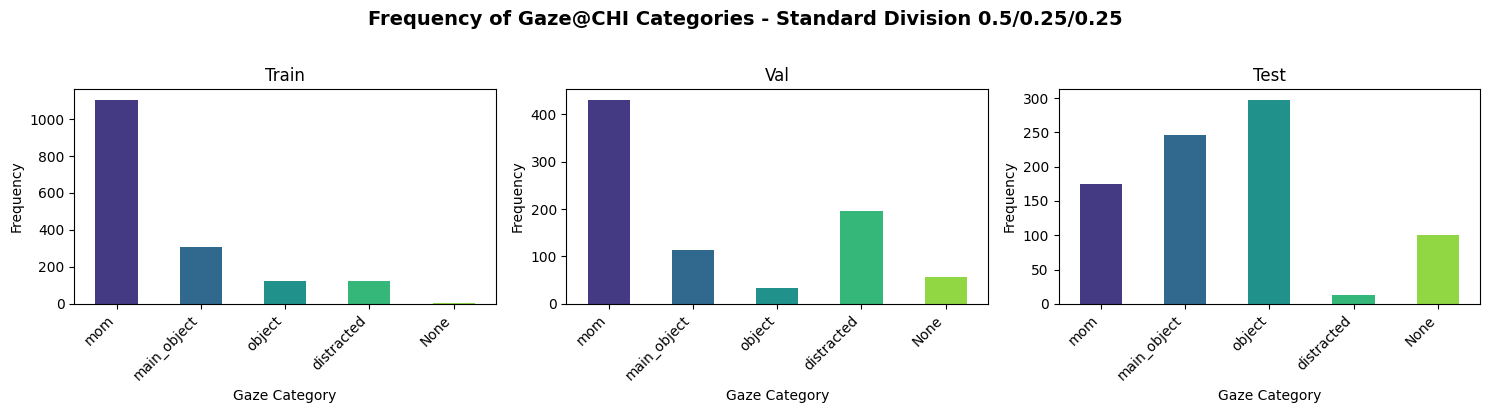

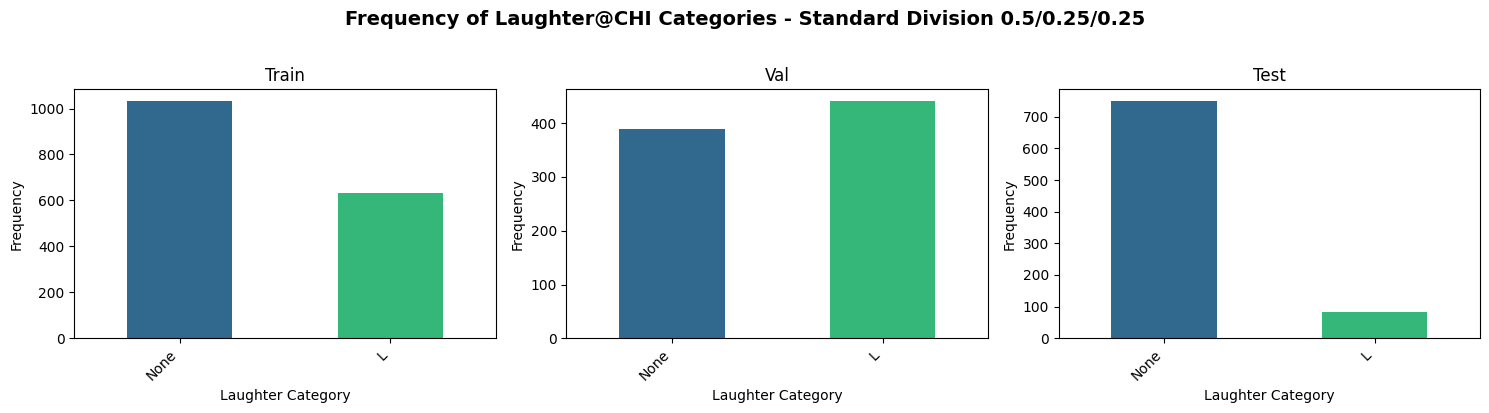

In [ ]:
split_and_plot(dataset=X, n_parts=1, train_size=0.5, val_size=0.25,
               tier='Gaze',
               global_title='Frequency of Gaze@CHI Categories - Standard Division 0.5/0.25/0.25')

split_and_plot(dataset=X, n_parts=1, train_size=0.5, val_size=0.25,
               tier='Laughter',
               global_title='Frequency of Laughter@CHI Categories - Standard Division 0.5/0.25/0.25')

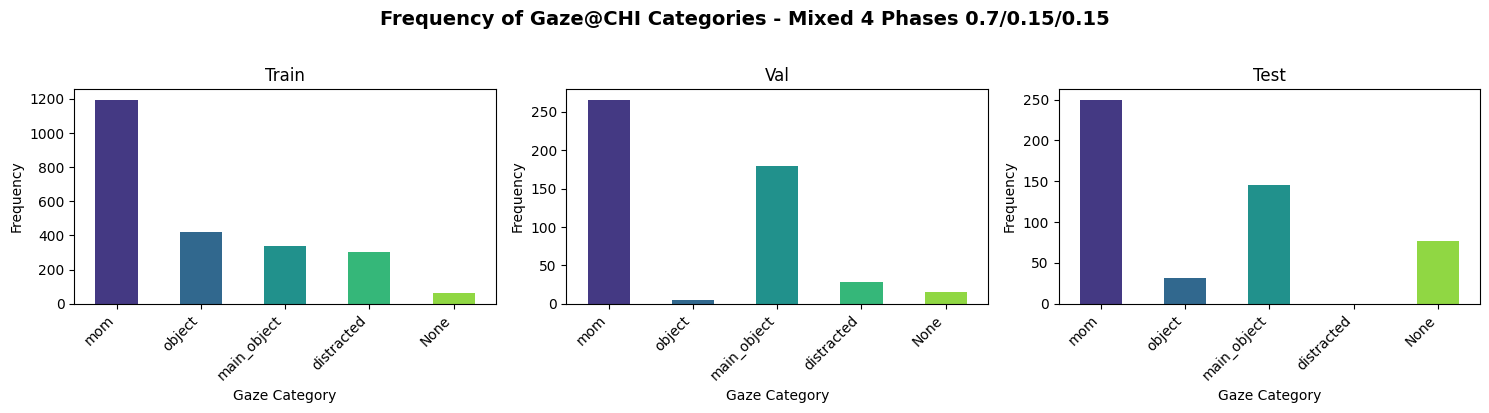

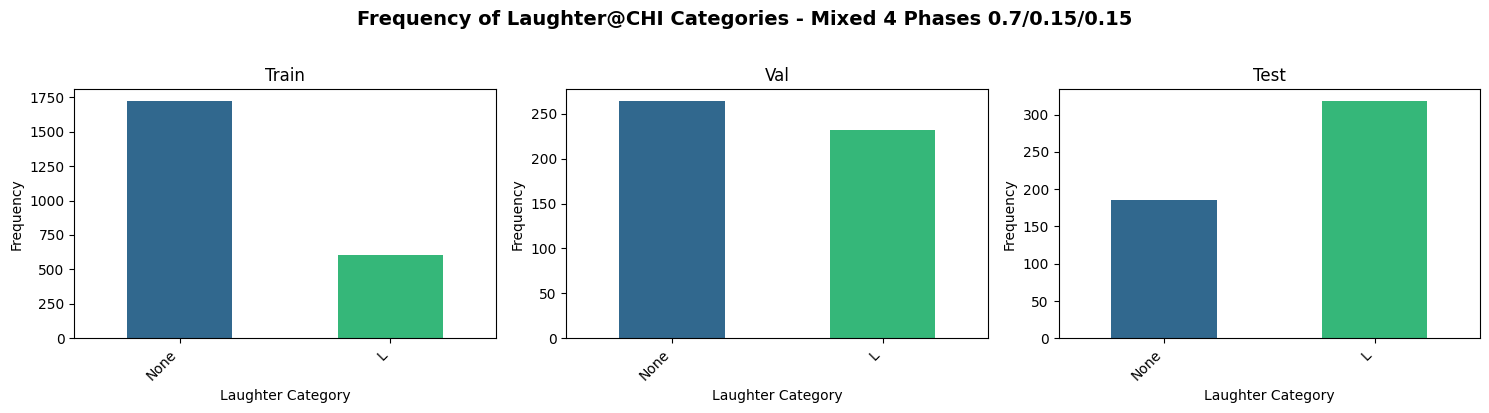

In [ ]:
split_and_plot(dataset=X, n_parts=4, train_size=0.7, val_size=0.15,
               tier='Gaze',
               global_title='Frequency of Gaze@CHI Categories - Mixed 4 Phases 0.7/0.15/0.15')

split_and_plot(dataset=X, n_parts=4, train_size=0.7, val_size=0.15,
               tier='Laughter',
               global_title='Frequency of Laughter@CHI Categories - Mixed 4 Phases 0.7/0.15/0.15')

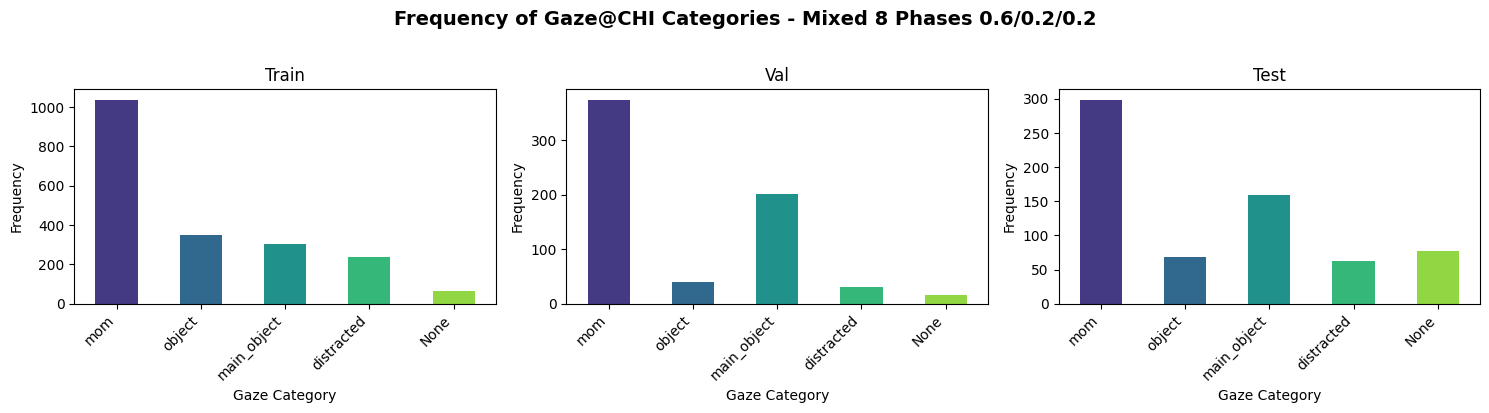

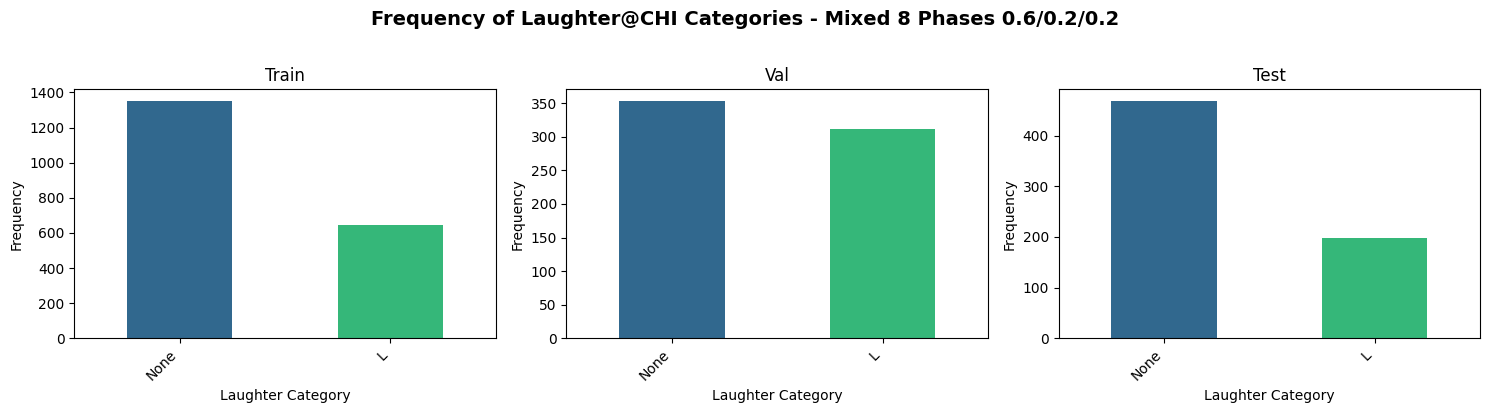

In [ ]:
split_and_plot(dataset=X, n_parts=8, train_size=0.6, val_size=0.2,
               tier='Gaze',
               global_title='Frequency of Gaze@CHI Categories - Mixed 8 Phases 0.6/0.2/0.2')

split_and_plot(dataset=X, n_parts=8, train_size=0.6, val_size=0.2,
               tier='Laughter',
               global_title='Frequency of Laughter@CHI Categories - Mixed 8 Phases 0.6/0.2/0.2')

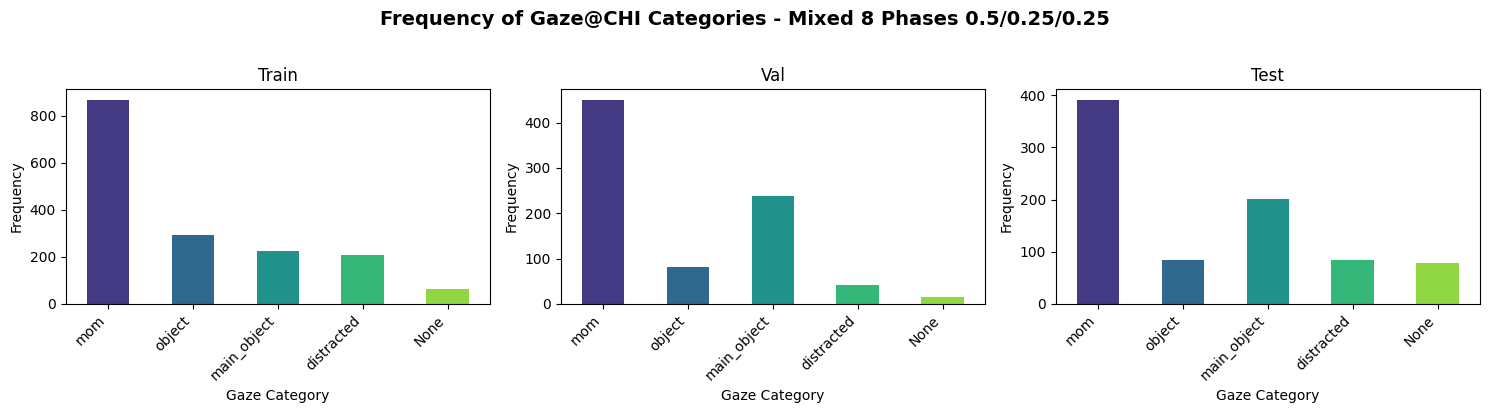

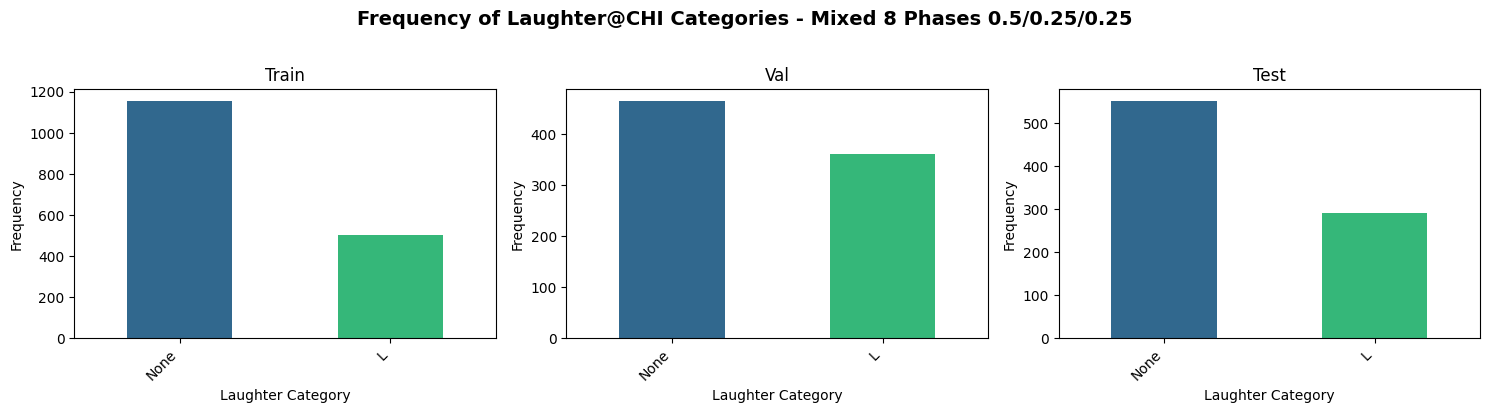

In [ ]:
split_and_plot(dataset=X, n_parts=8, train_size=0.5, val_size=0.25,
               tier='Gaze',
               global_title='Frequency of Gaze@CHI Categories - Mixed 8 Phases 0.5/0.25/0.25')

split_and_plot(dataset=X, n_parts=8, train_size=0.5, val_size=0.25,
               tier='Laughter',
               global_title='Frequency of Laughter@CHI Categories - Mixed 8 Phases 0.5/0.25/0.25')

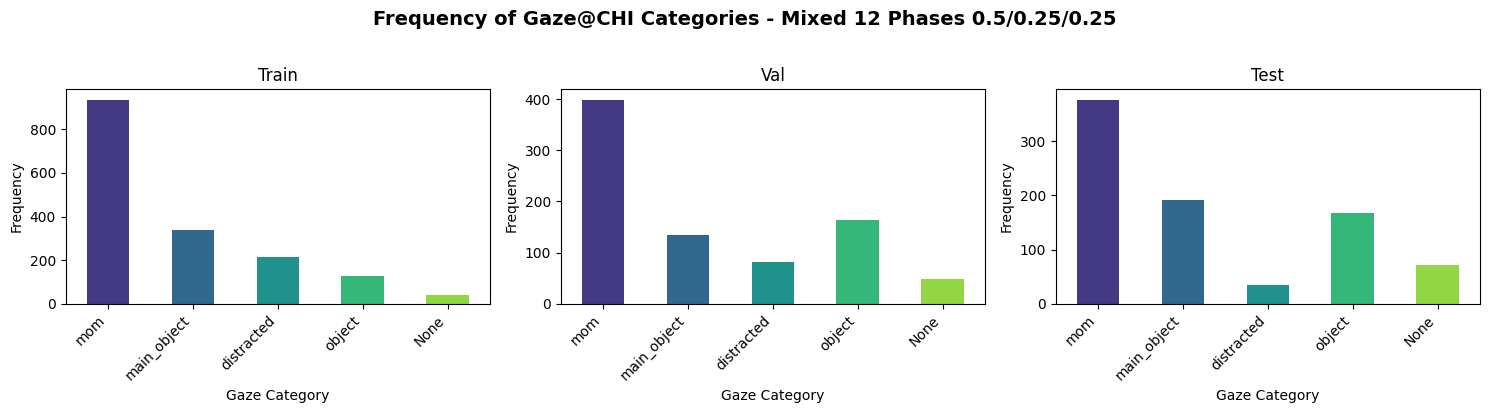

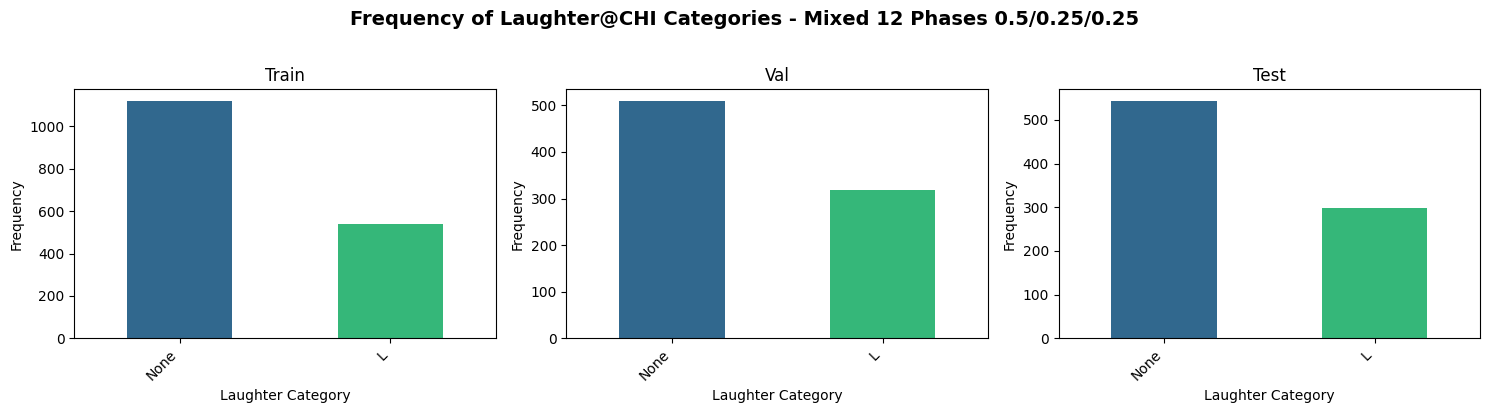

In [ ]:
split_and_plot(dataset=X, n_parts=12, train_size=0.5, val_size=0.25,
               tier='Gaze',
               global_title='Frequency of Gaze@CHI Categories - Mixed 12 Phases 0.5/0.25/0.25')

split_and_plot(dataset=X, n_parts=12, train_size=0.5, val_size=0.25,
               tier='Laughter',
               global_title='Frequency of Laughter@CHI Categories - Mixed 12 Phases 0.5/0.25/0.25')